In [1]:
import glob
import re

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import Graph

field_strength = [30, 60, 125, 250, 500, 1000, 2000, 3500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]

The below two cells load the necessary files and compute the diffusion coefficients. At various fields, $100$ electrons were spawned and allowed to propagate for $10$ ns.

In [2]:
file_tree = {}

for field in field_strength:
    for file in glob.glob(f'lar-diffusion/{field}/*.txt'):
        key = int(re.search(r'(\d*)(?:V)', file).group(1))
        if (key in file_tree):
            file_tree[key].append(file)
        else:
            file_tree[key] = [file]

The below shows the estimation process of the diffusion coefficients: the variance of each coordinate of the electrons in the cloud is plotted as a function of time. The diffusion coefficients are the slopes of these lines.

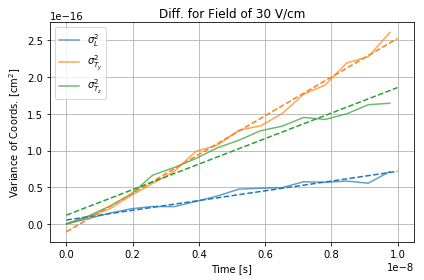

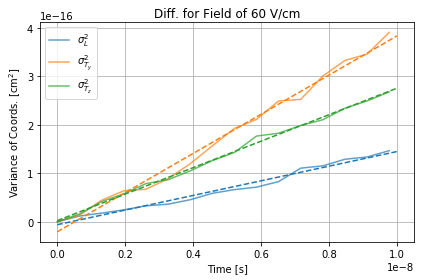

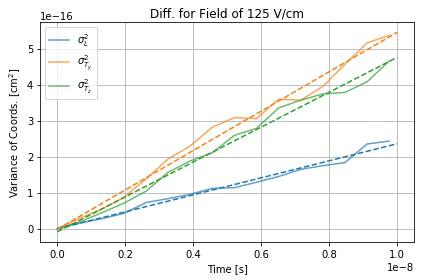

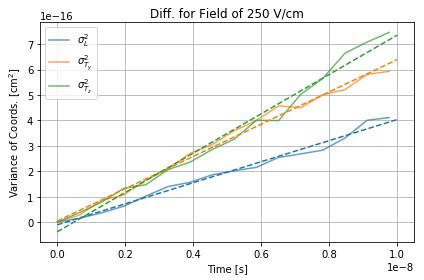

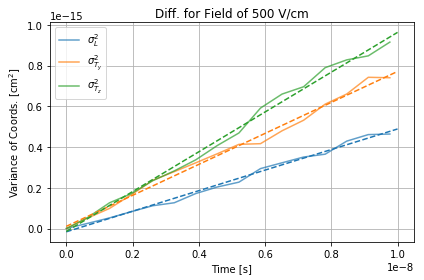

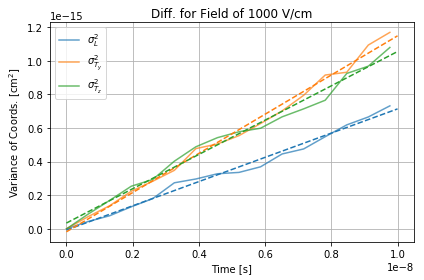

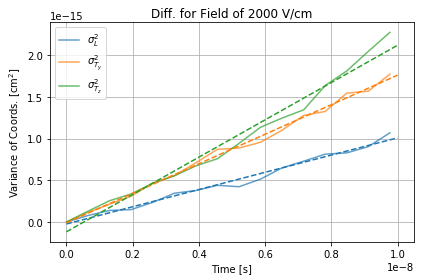

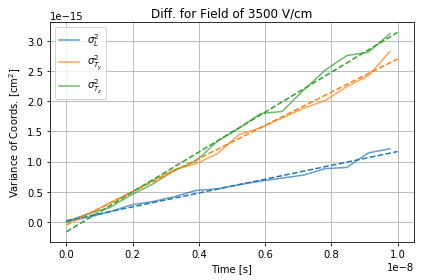

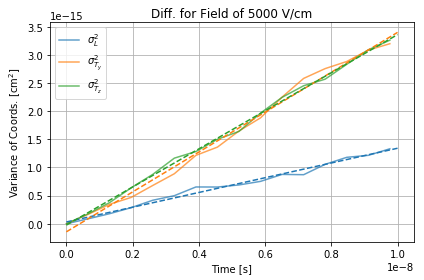

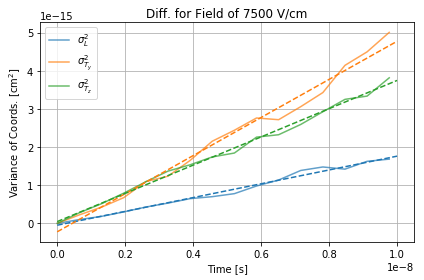

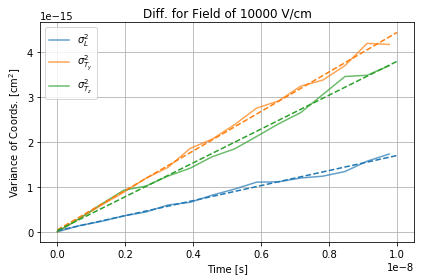

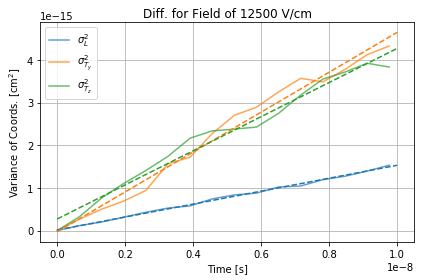

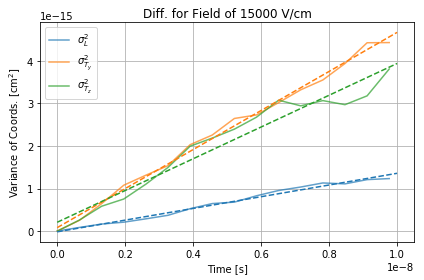

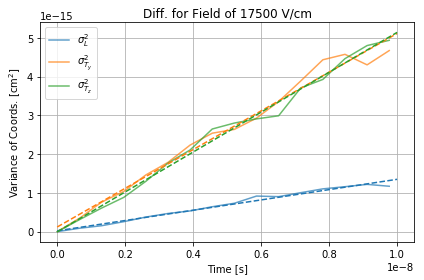

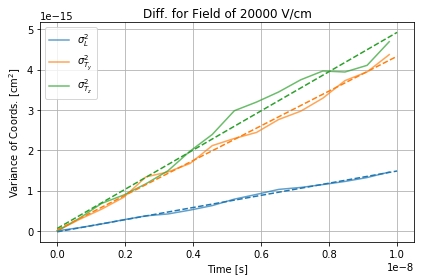

In [3]:
for key, value in sorted(file_tree.items()):
    t = []
    D_L = []
    D_Ty = []
    D_Tz = []
    
    group = Graph(value)
    
    min_length = np.inf
    
    for i in range(group.n):
        if len(group.t[i]) < min_length:
            min_length = len(group.t[i])
            
    indices = np.arange(0, min_length, 100)

    for i in indices:
        t_avg = np.mean([k[i] for k in group.t]) * 1e-9

        x_vals = [k[i] * 1e-8 for k in group.x]
        y_vals = [k[i] * 1e-8 for k in group.y]
        z_vals = [k[i] * 1e-8 for k in group.z]
        
        t.append(t_avg)

        this_D_L = np.var(x_vals, ddof=1)
        D_L.append(this_D_L)

        this_D_Ty = np.var(y_vals, ddof=1)
        D_Ty.append(this_D_Ty)

        this_D_Tz = np.var(z_vals, ddof=1)
        D_Tz.append(this_D_Tz)
        
    # plt.rcParams['font.size'] = 14
    # plt.rcParams['font.family'] = 'serif'
    # fig = plt.figure(figsize=(6, 6))
    
    plt.plot(t, D_L, alpha=0.7, label='$\sigma_L^2$')
    plt.plot(t, D_Ty, alpha=0.7, label='$\sigma_{T_y}^2$')
    plt.plot(t, D_Tz, alpha=0.7, label='$\sigma_{T_z}^2$')
    
    slope_L, intercept_L, r_value, p_value, std_err = stats.linregress(t, D_L)
    slope_Ty, intercept_Ty, r_value, p_value, std_err = stats.linregress(t, D_Ty)
    slope_Tz, intercept_Tz, r_value, p_value, std_err = stats.linregress(t, D_Tz)
    
    x = np.linspace(0, 1e-8, 10)
    
    plt.plot(x, slope_L * x + intercept_L, 'C0--')
    plt.plot(x, slope_Ty * x + intercept_Ty, 'C1--')
    plt.plot(x, slope_Tz * x + intercept_Tz, 'C2--')
    
    plt.xlabel('Time [s]')
    plt.ylabel('Variance of Coords. [cm$^2$]')
    
    plt.title(f'Diff. for Field of {key} V/cm')
    
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # plt.savefig(f'lar_diffusion_at_{key}.pdf', bbox_inches='tight')

In [4]:
threshold = 3 # Throw out points more than n standard deviations above the mean

D_L_all = []
D_Ty_all = []
D_Tz_all = []

for key, value in sorted(file_tree.items()):
    group = Graph(value)

    t_avg = np.mean([k[-1] for k in group.t])

    x_vals = np.array([k[-1] for k in group.x])
    y_vals = np.array([k[-1] for k in group.y])
    z_vals = np.array([k[-1] for k in group.z])

    this_D_L = np.var([x_vals[k] for k in np.where(np.abs(stats.zscore(x_vals)) < threshold)[0]], ddof=1) / t_avg * 1e1
    D_L_all.append(this_D_L)
    
    this_D_Ty = np.var([y_vals[k] for k in np.where(np.abs(stats.zscore(y_vals)) < threshold)[0]], ddof=1) / t_avg * 1e1
    D_Ty_all.append(this_D_Ty)
    
    this_D_Tz = np.var([z_vals[k] for k in np.where(np.abs(stats.zscore(z_vals)) < threshold)[0]], ddof=1) / t_avg * 1e1
    D_Tz_all.append(this_D_Tz)

The cell below plots the diffusion coefficients as a function of bulk field strength. The data refers to https://lar.bnl.gov/properties/index.html#e-trans.

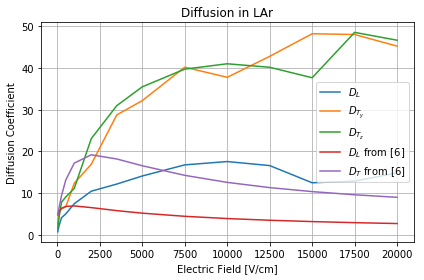

In [5]:
# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

plt.plot(field_strength, D_L_all, label='$D_L$')
plt.plot(field_strength, D_Ty_all, label='$D_{T_y}$')
plt.plot(field_strength, D_Tz_all, label='$D_{T_z}$')
plt.plot(field_strength, [4.8078, 5.2069, 5.7826, 6.3684, 6.8223, 6.9404, 6.5406, 5.8135, 5.2090, 4.4562, 3.9163, 3.5097, 3.1910, 2.9333, 2.7199], label='$D_L$ from [6]')
plt.plot(field_strength, [4.8629, 5.5250, 6.9602, 9.4303, 13.1586, 17.2051, 19.1958, 18.1949, 16.5709, 14.2722, 12.5855, 11.3328, 10.3730, 9.6162, 9.0048], label='$D_T$ from [6]')

plt.xlabel('Electric Field [V/cm]')
plt.ylabel('Diffusion Coefficient')
plt.title('Diffusion in LAr')

plt.legend(loc=0)
plt.grid()
plt.tight_layout()
plt.show()

# plt.savefig('lar_diffusion.pdf', bbox_inches='tight')

For our own purposes, we display scatter plots and histograms of snapshots of our simulated electrons.

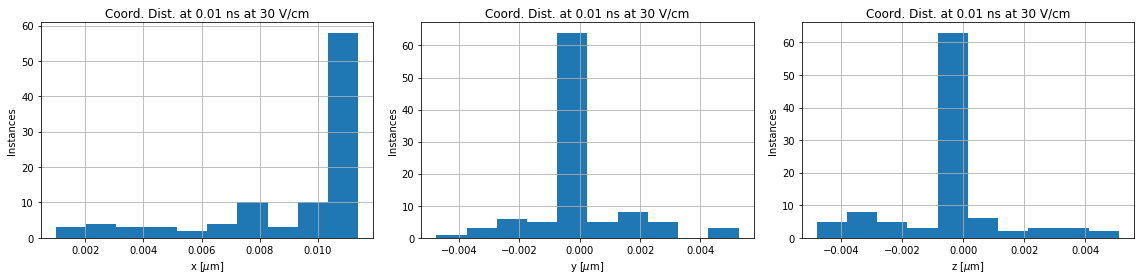

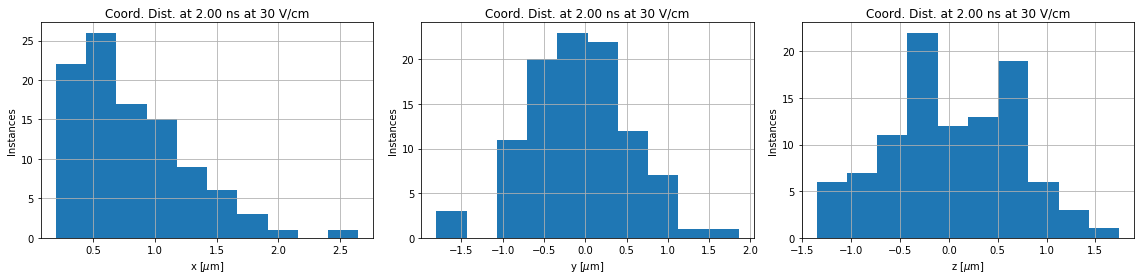

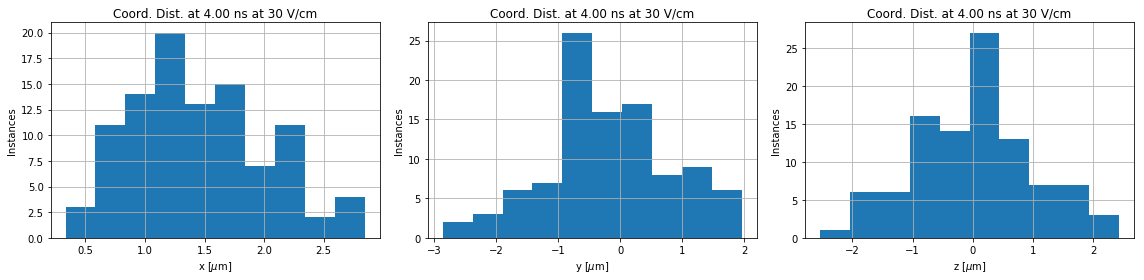

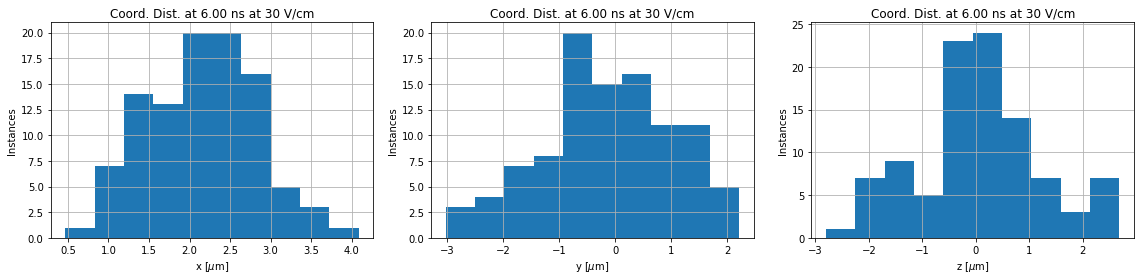

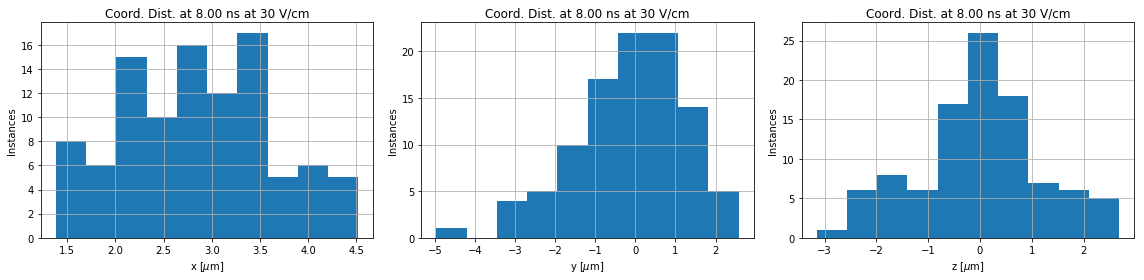

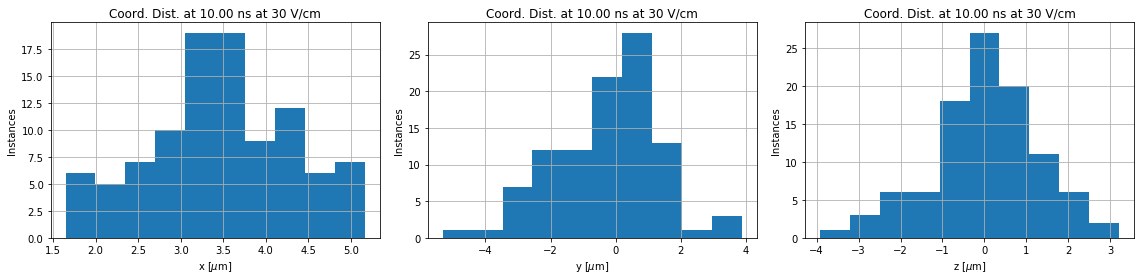

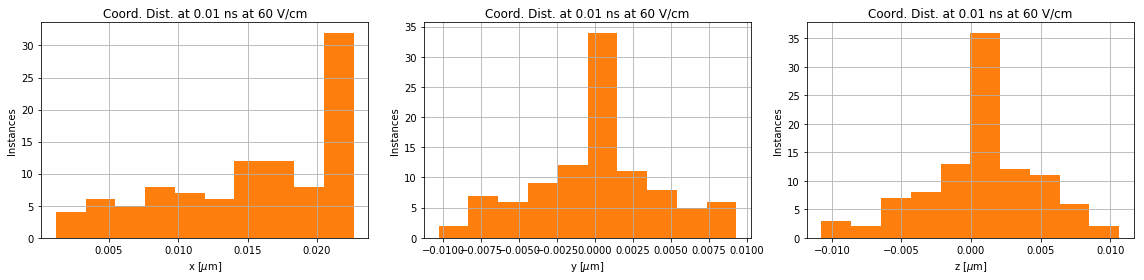

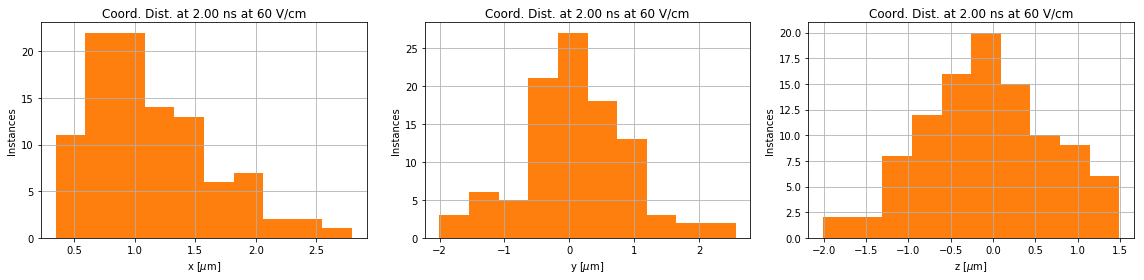

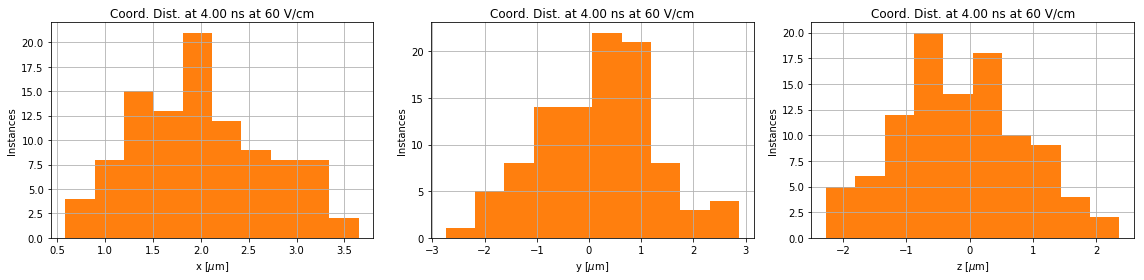

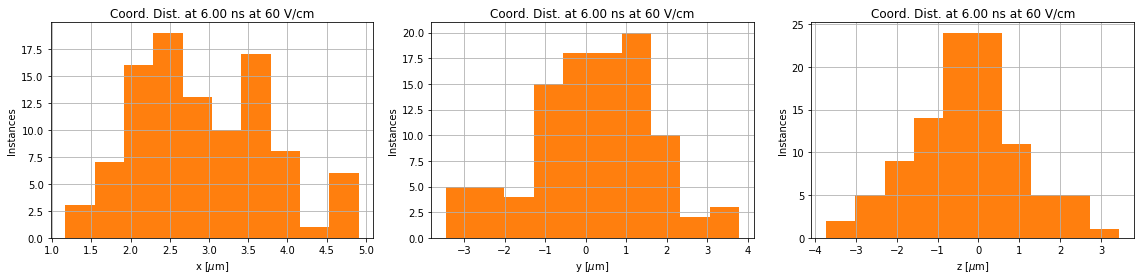

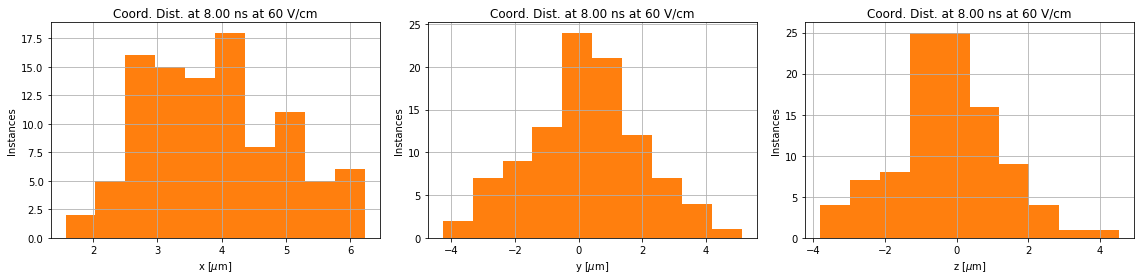

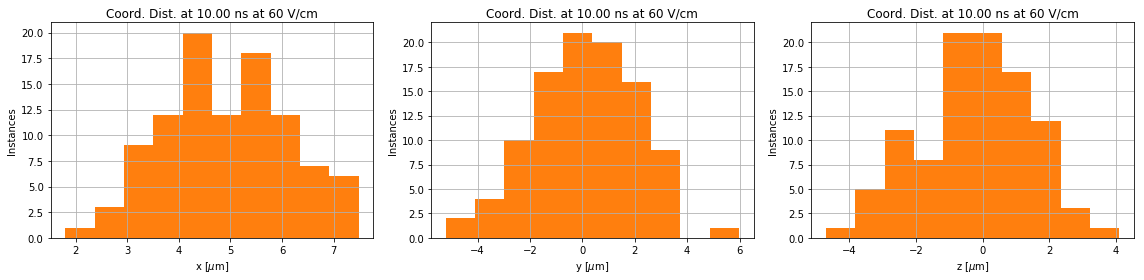

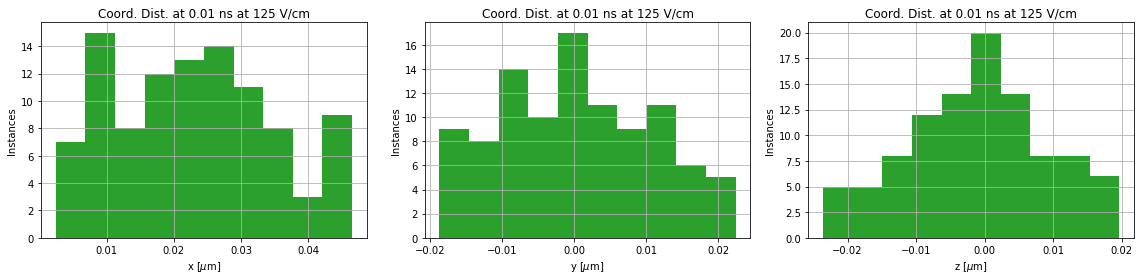

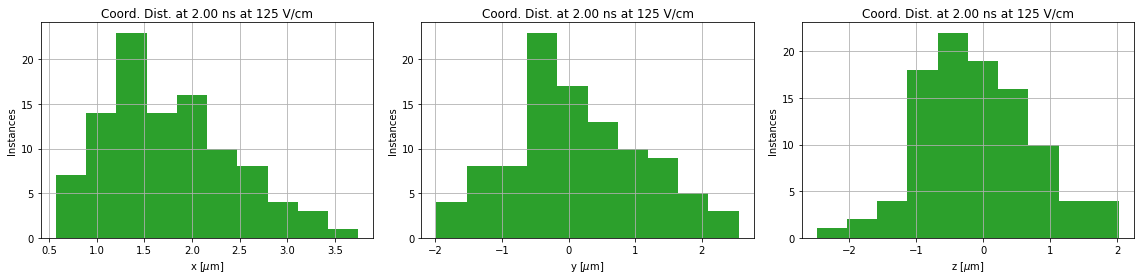

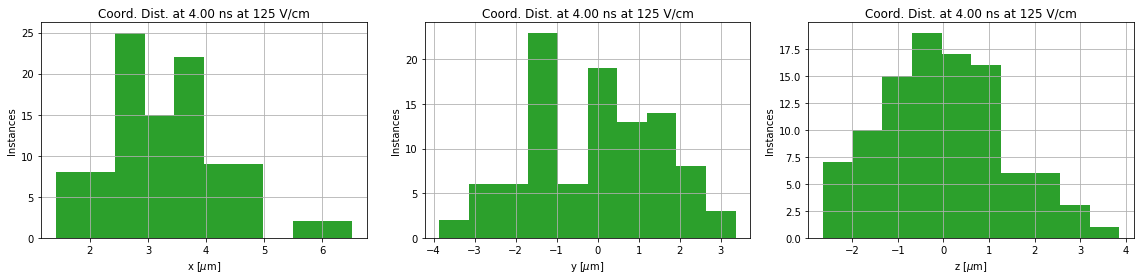

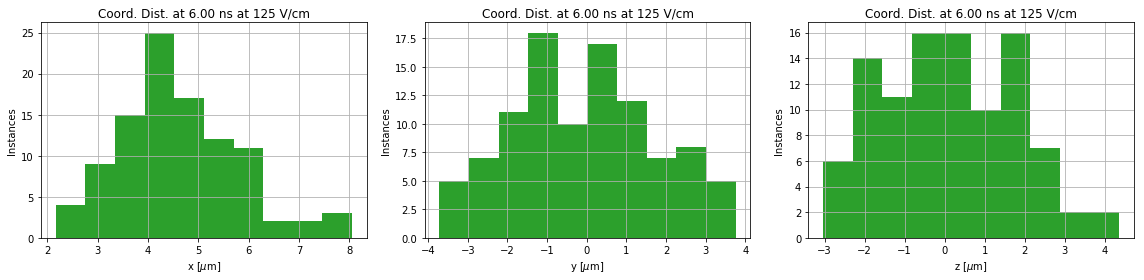

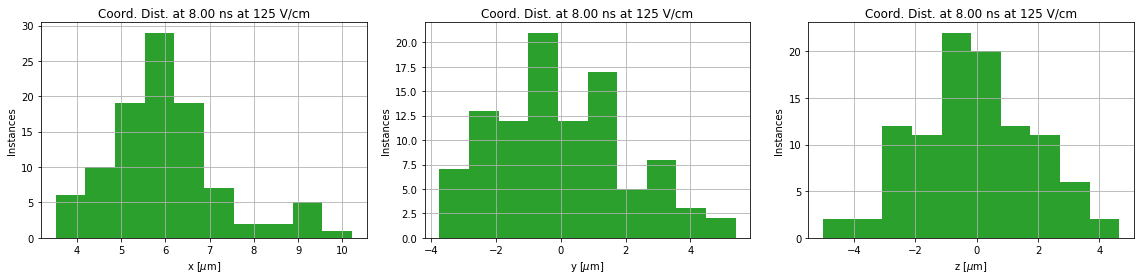

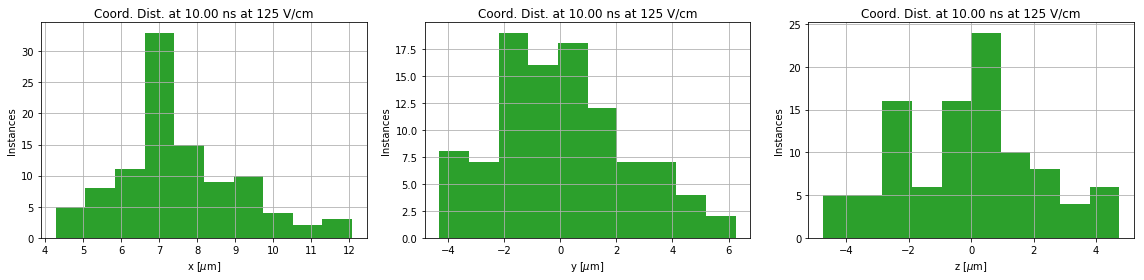

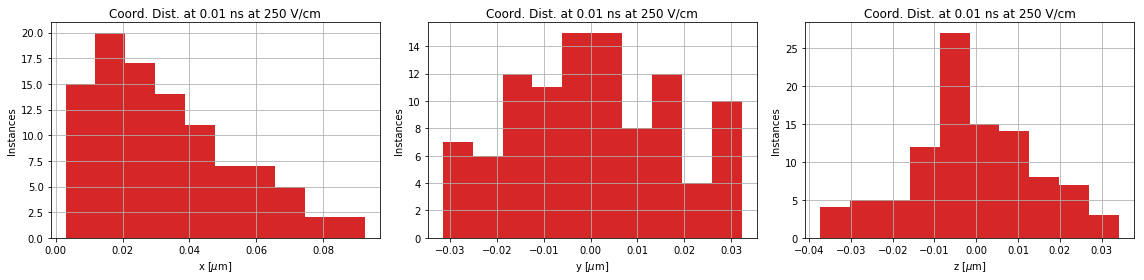

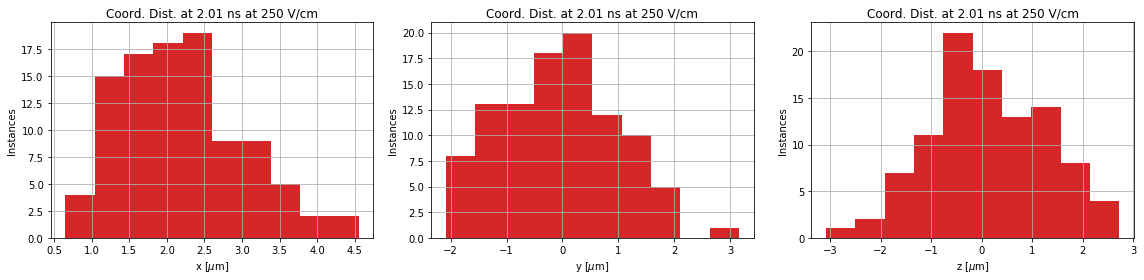

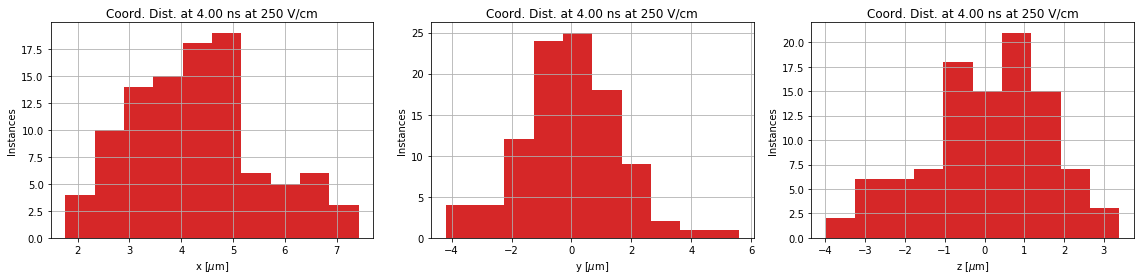

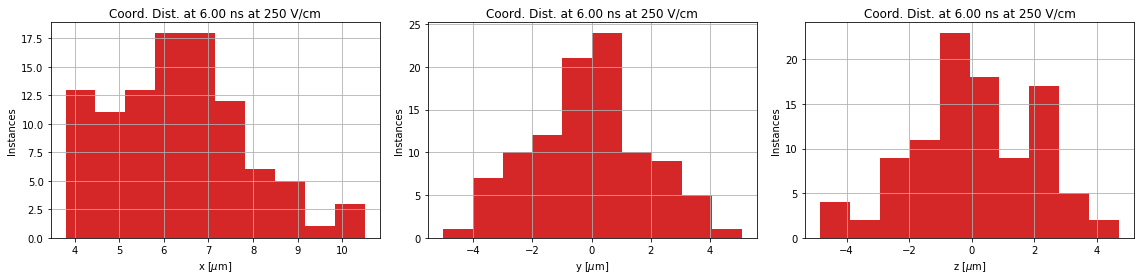

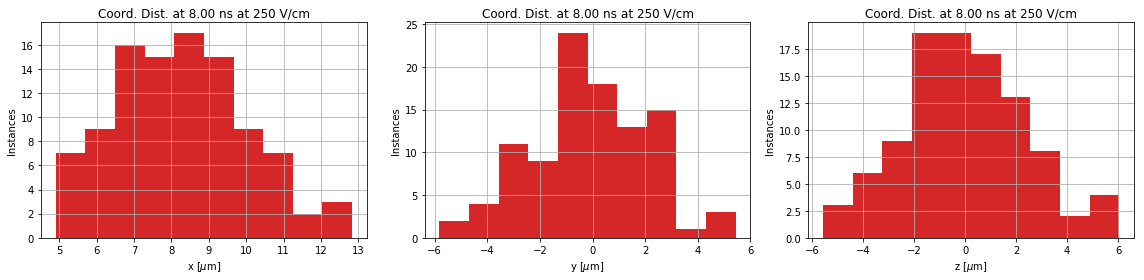

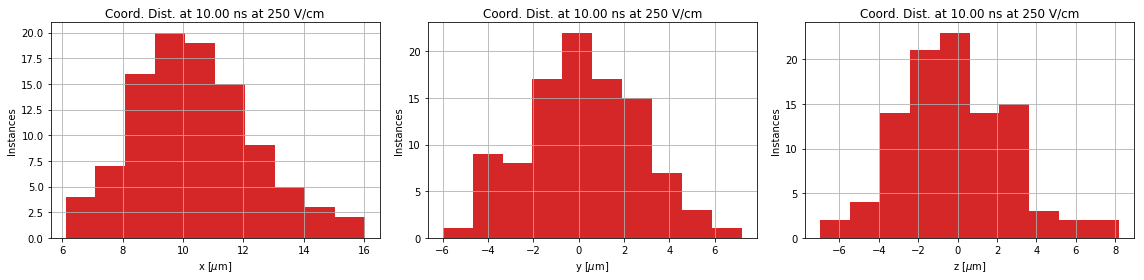

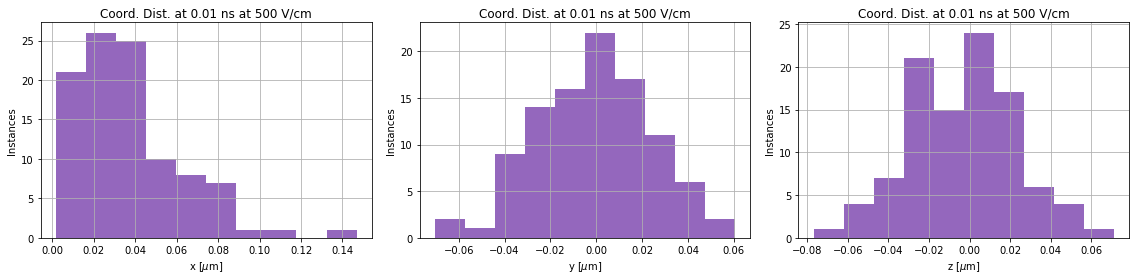

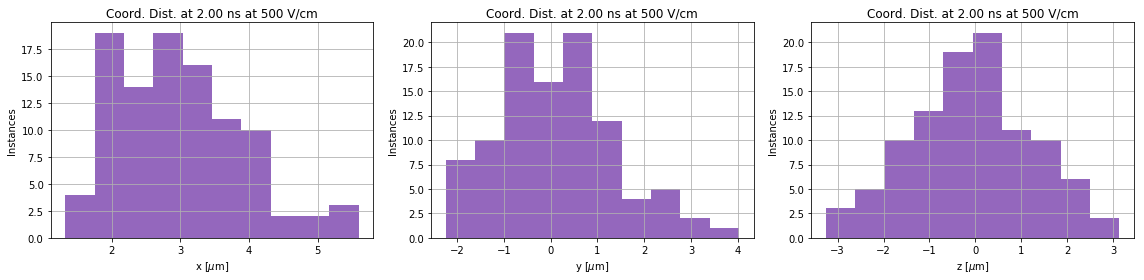

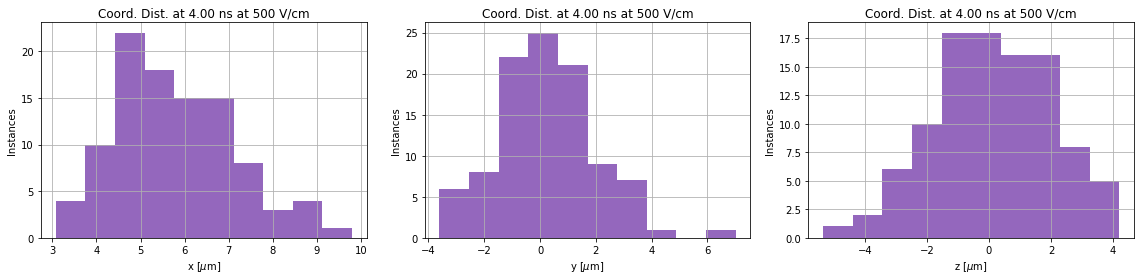

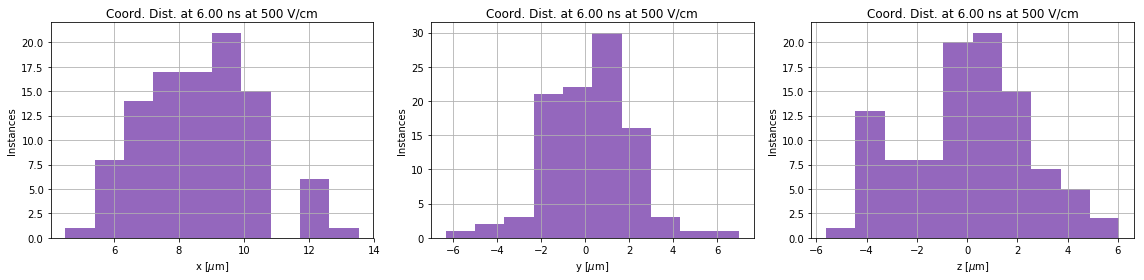

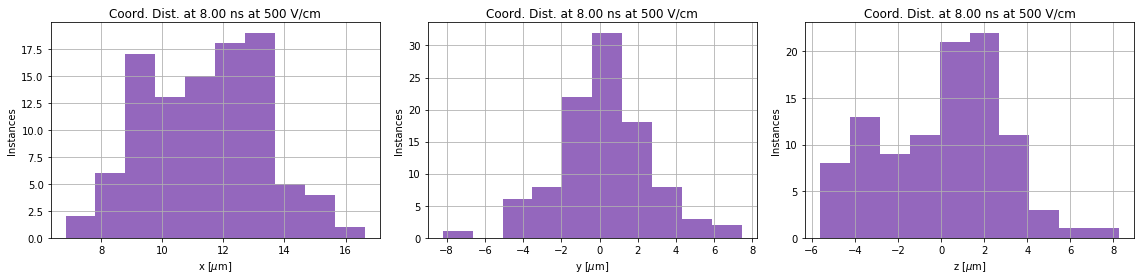

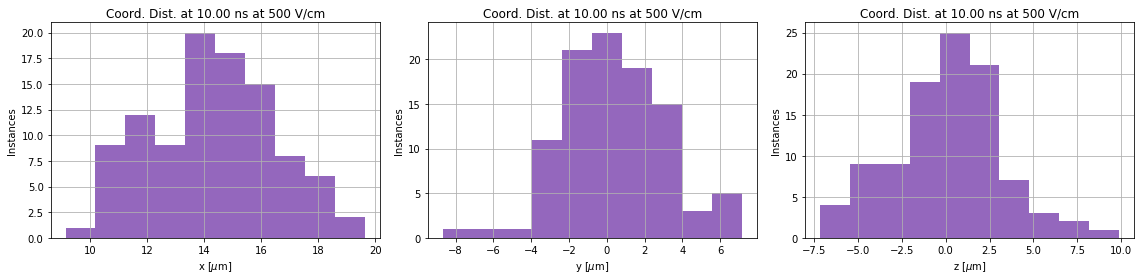

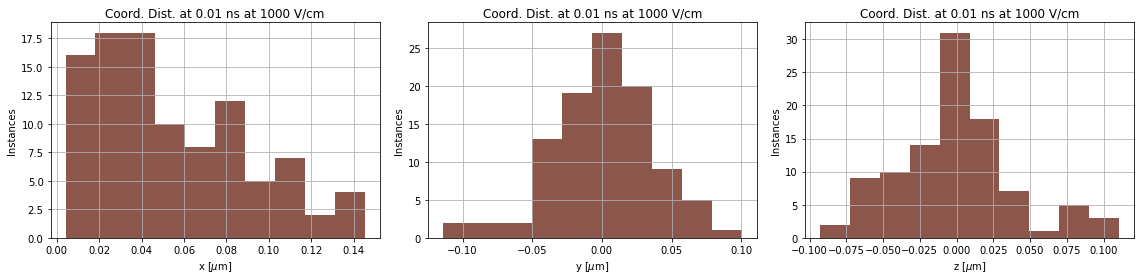

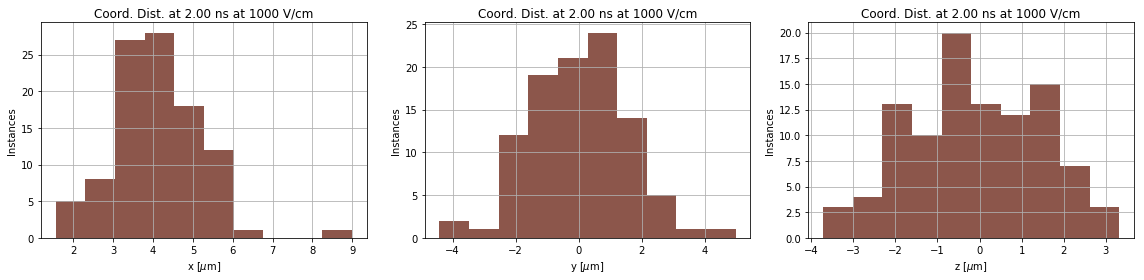

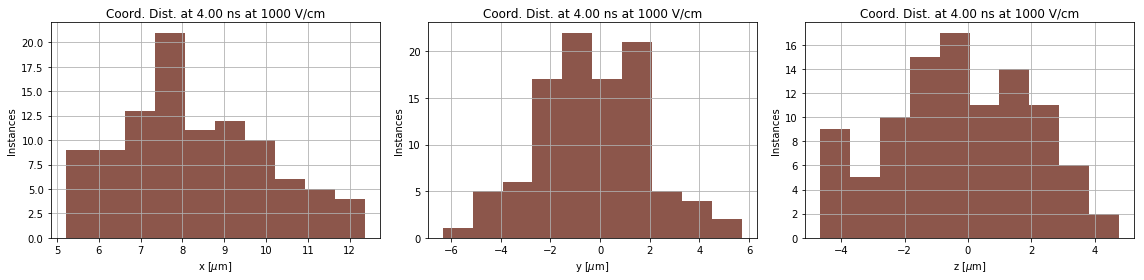

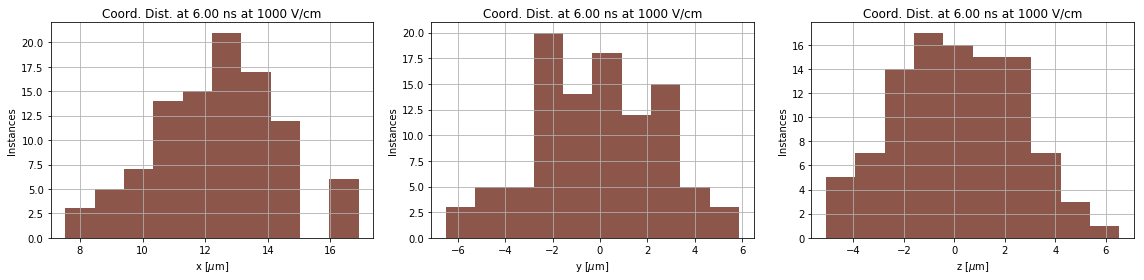

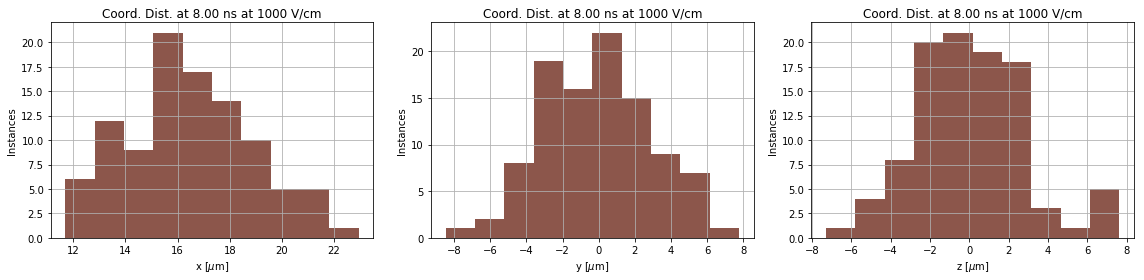

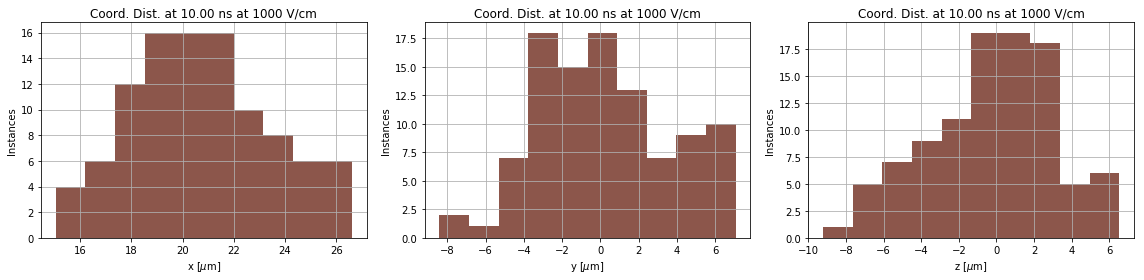

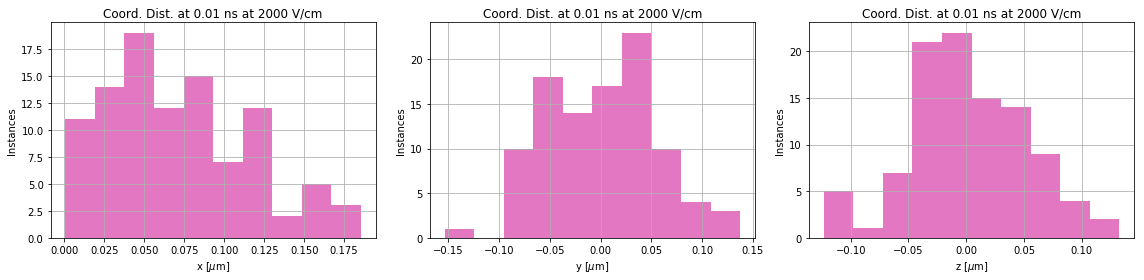

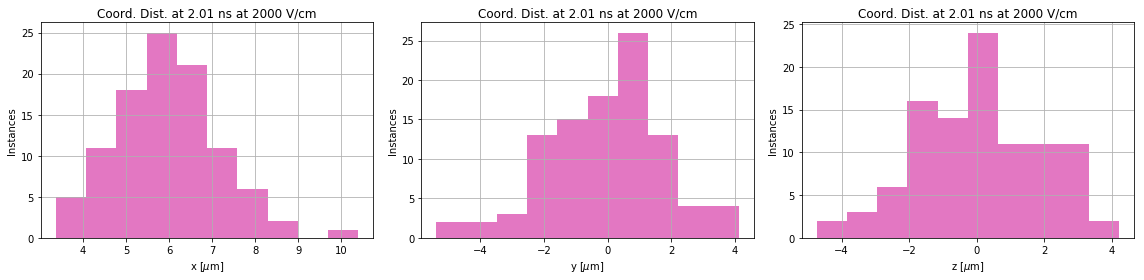

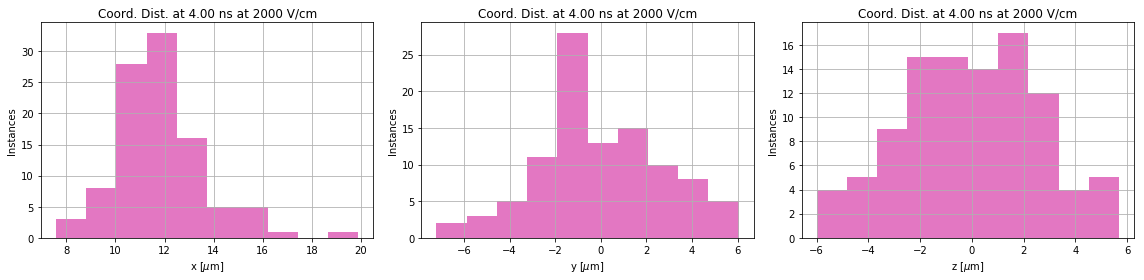

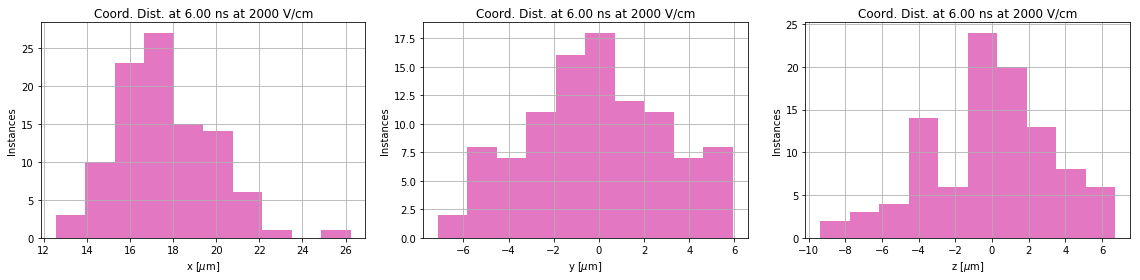

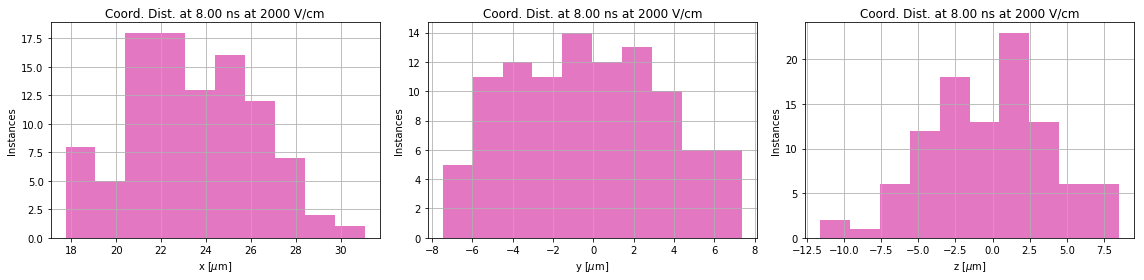

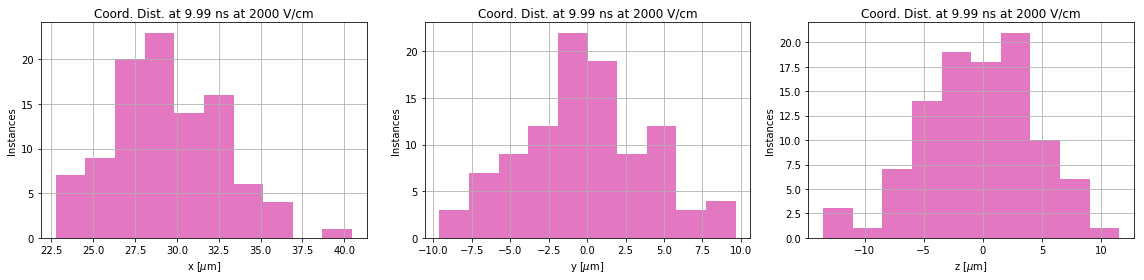

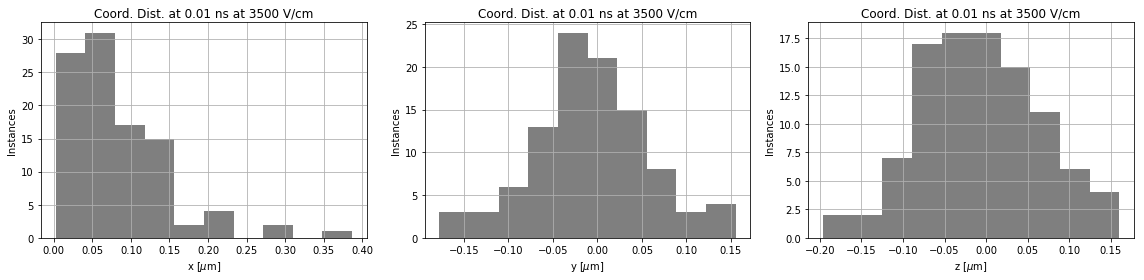

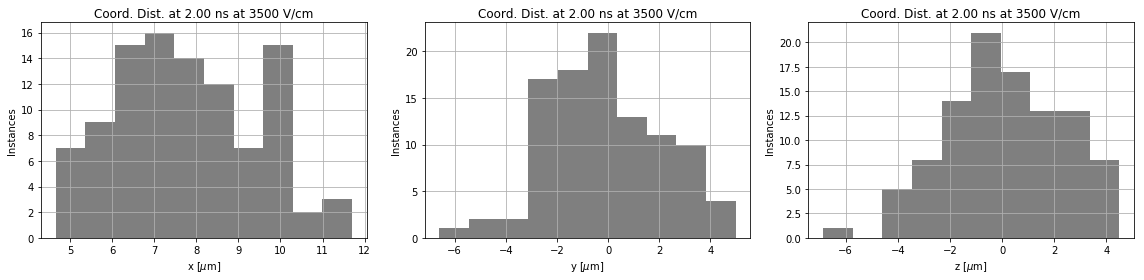

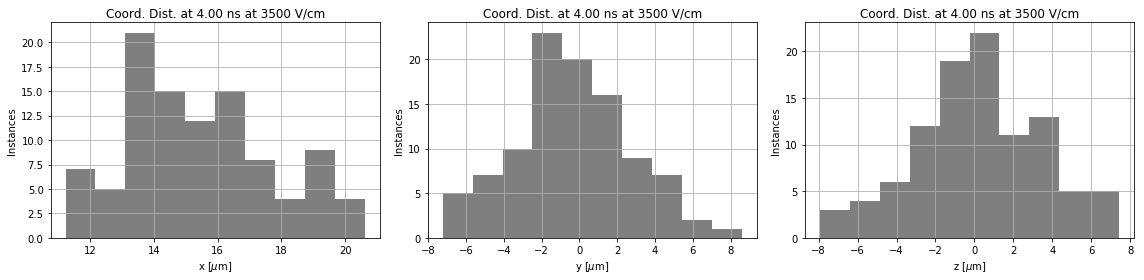

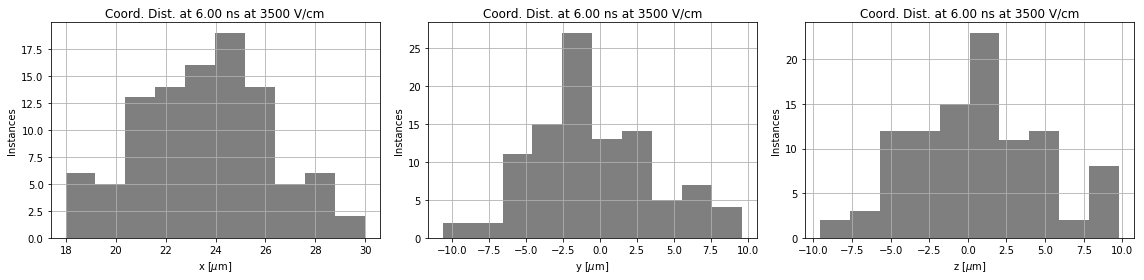

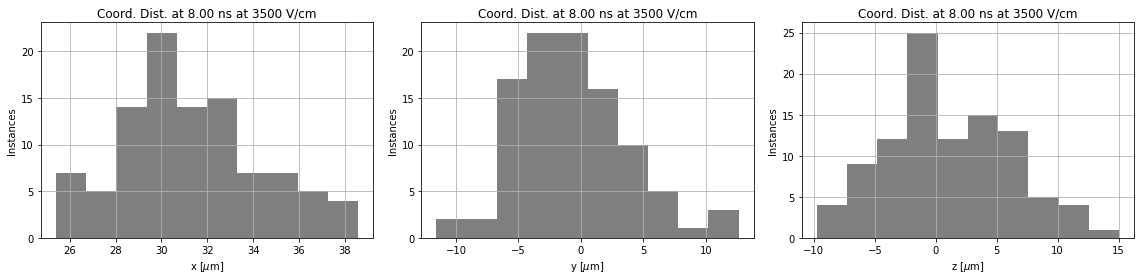

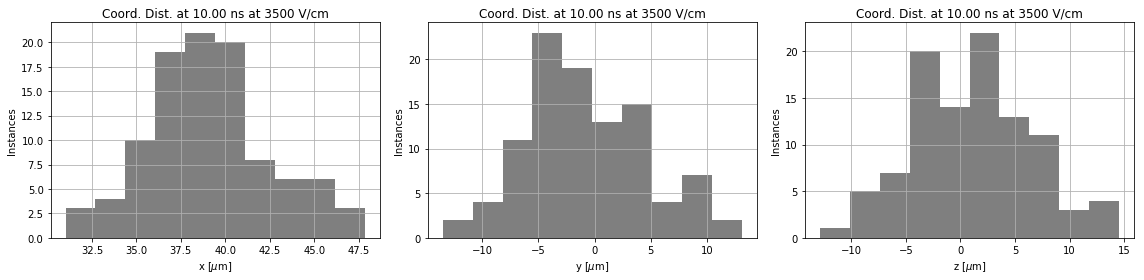

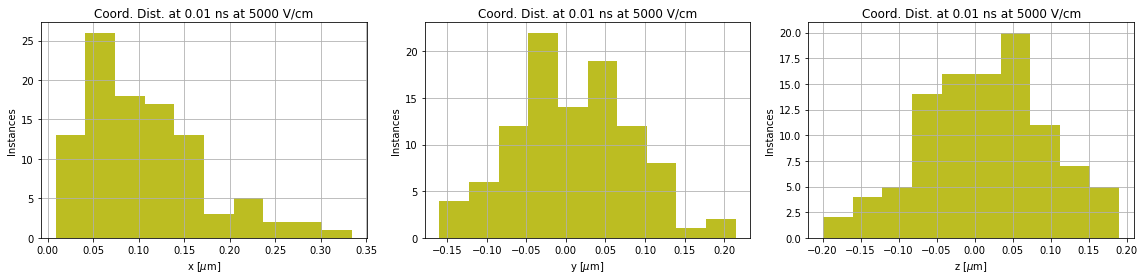

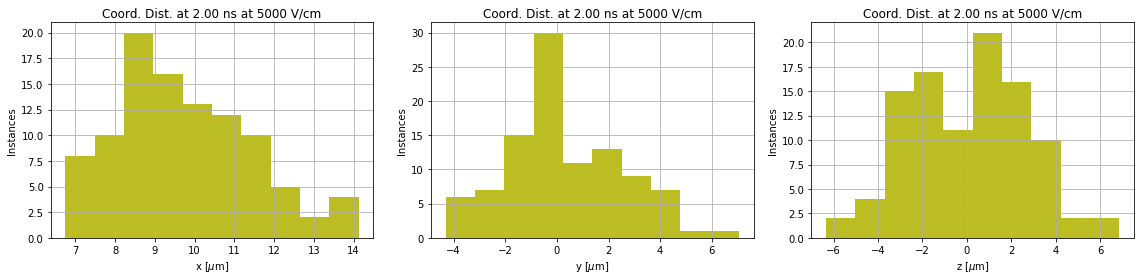

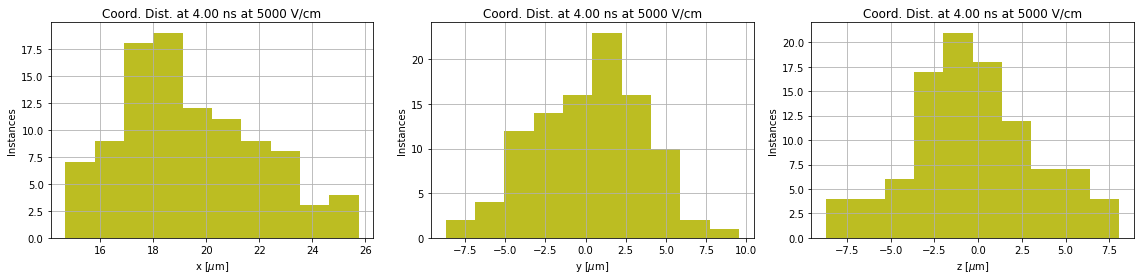

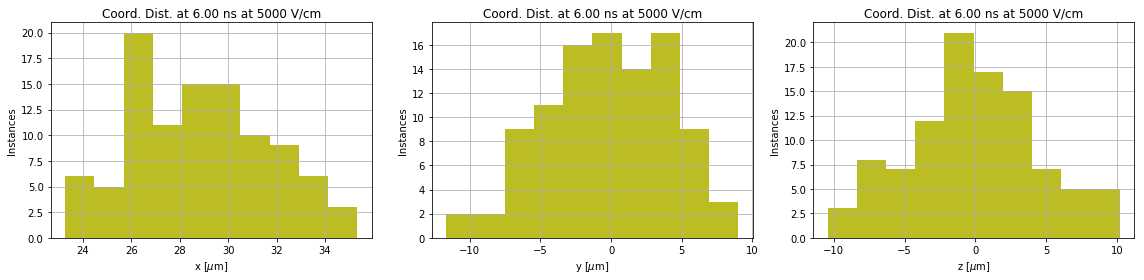

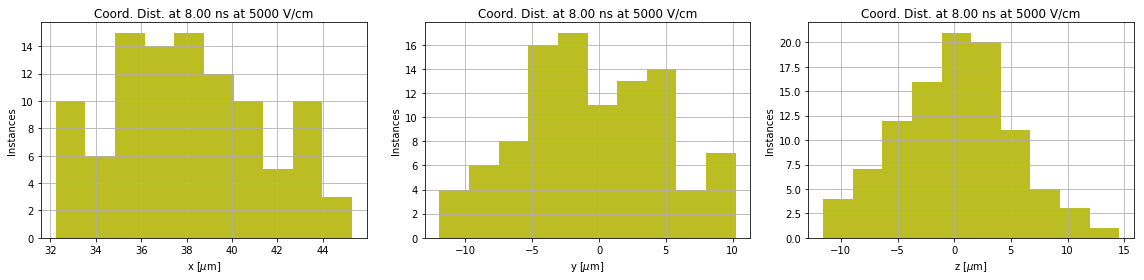

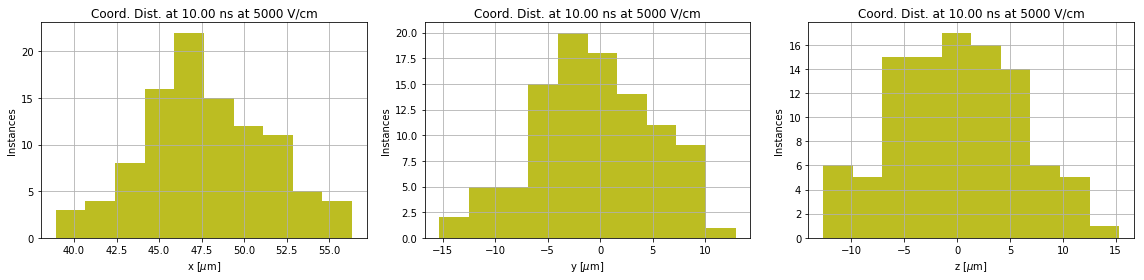

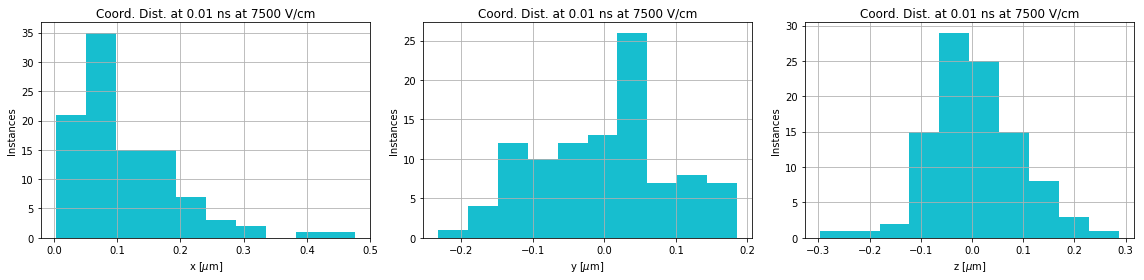

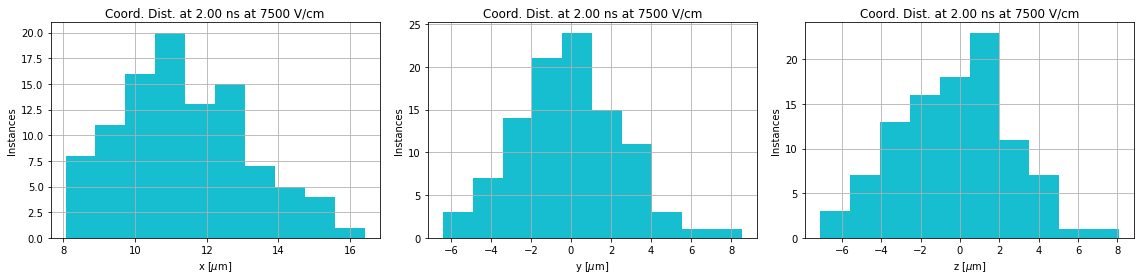

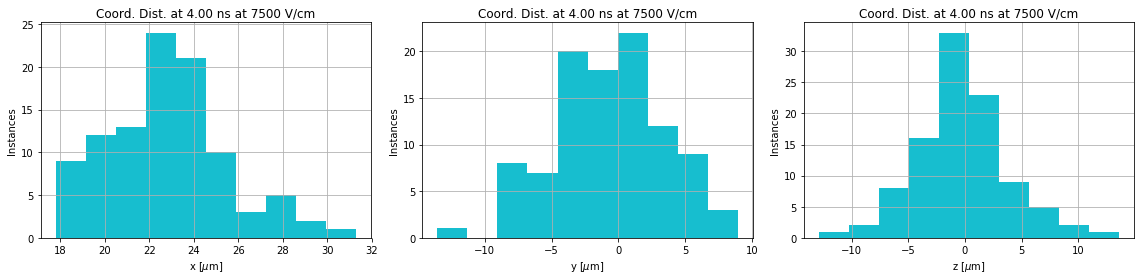

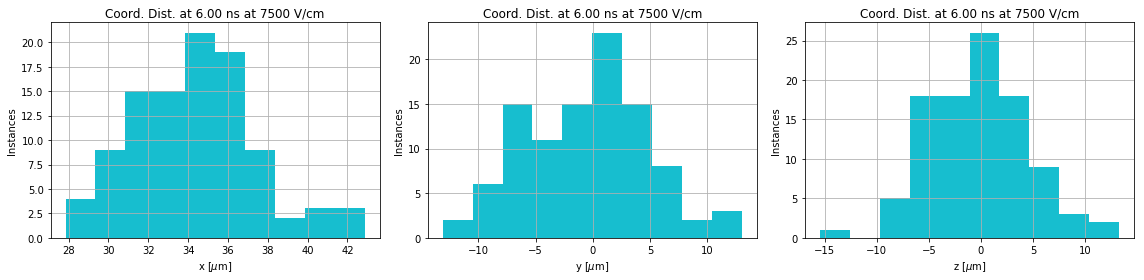

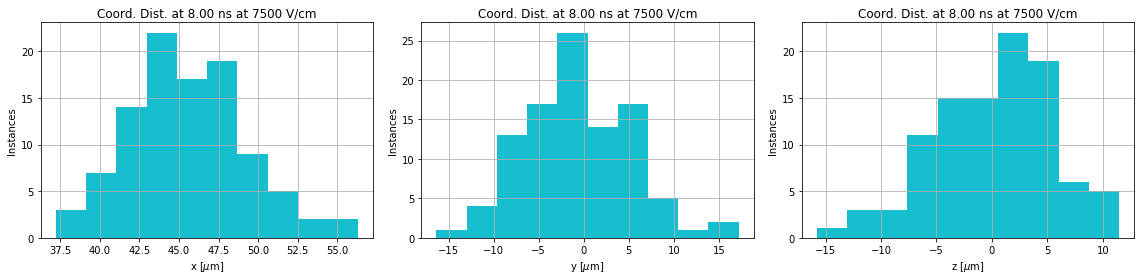

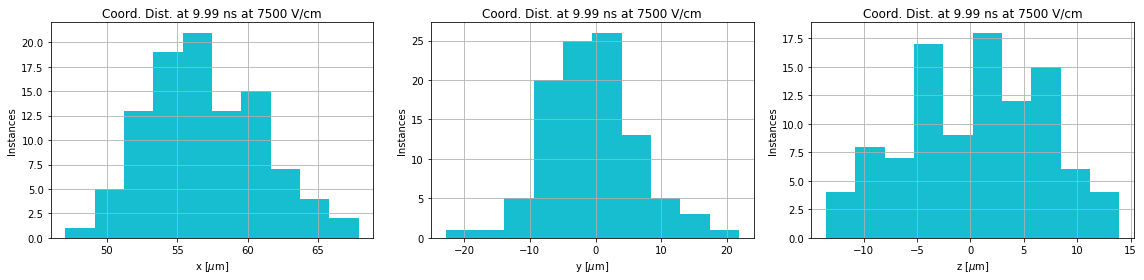

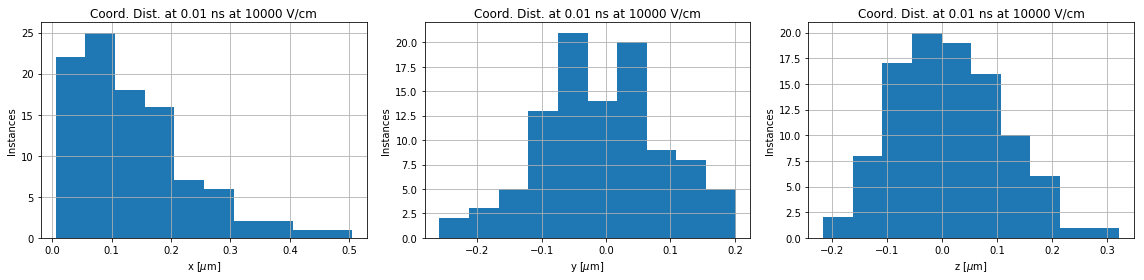

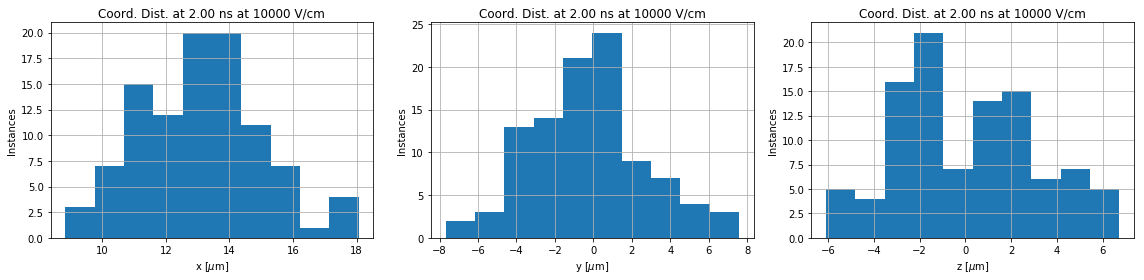

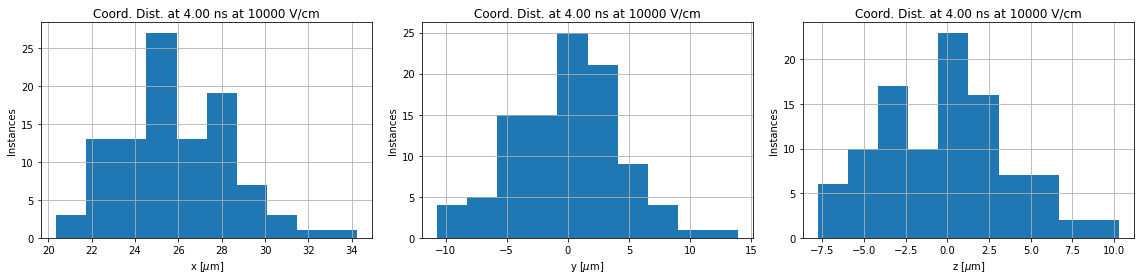

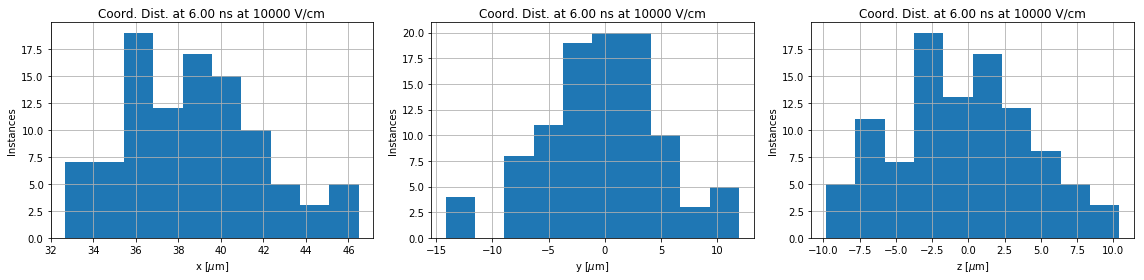

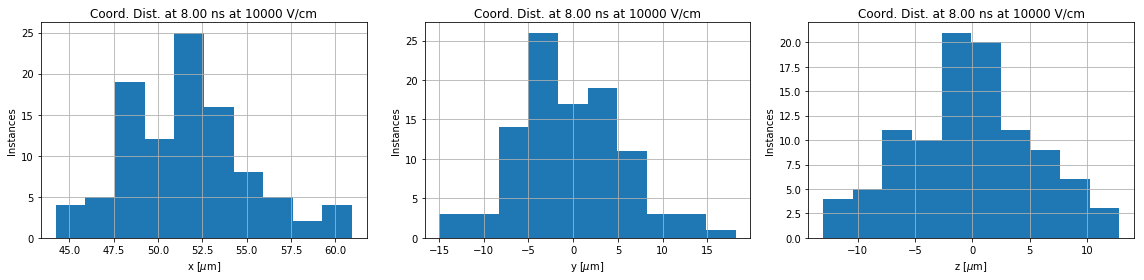

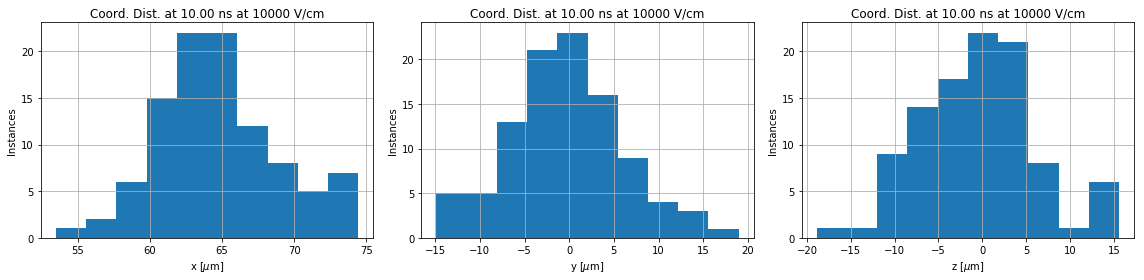

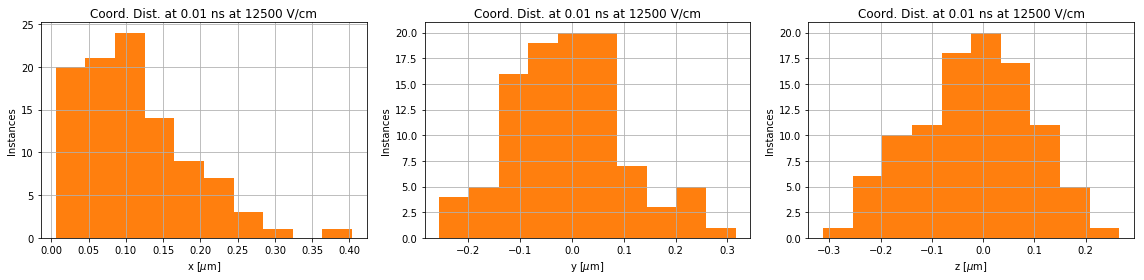

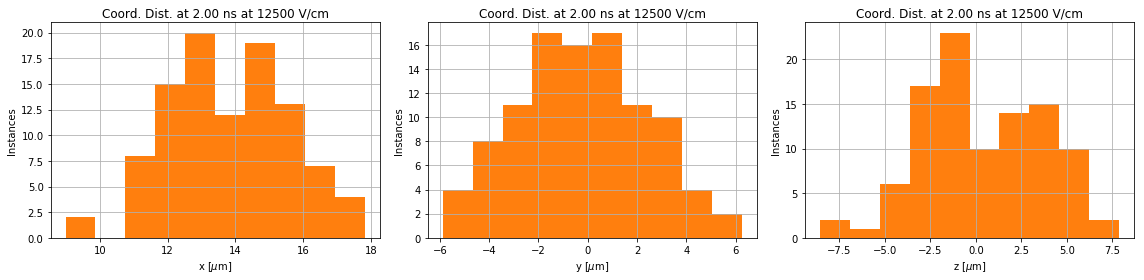

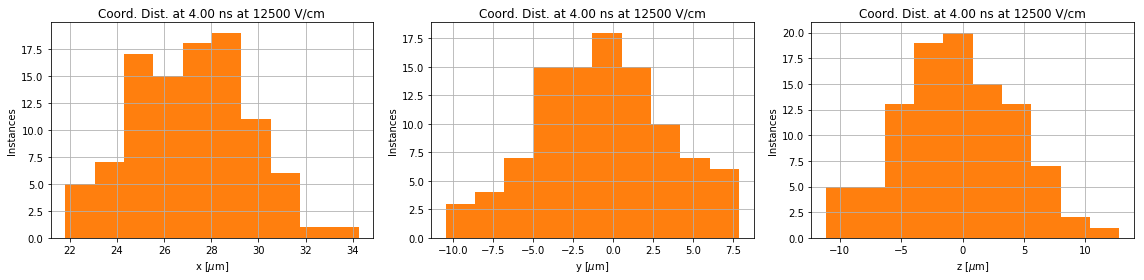

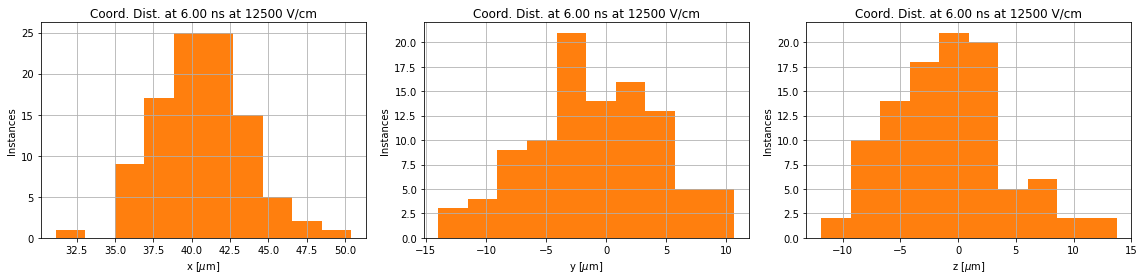

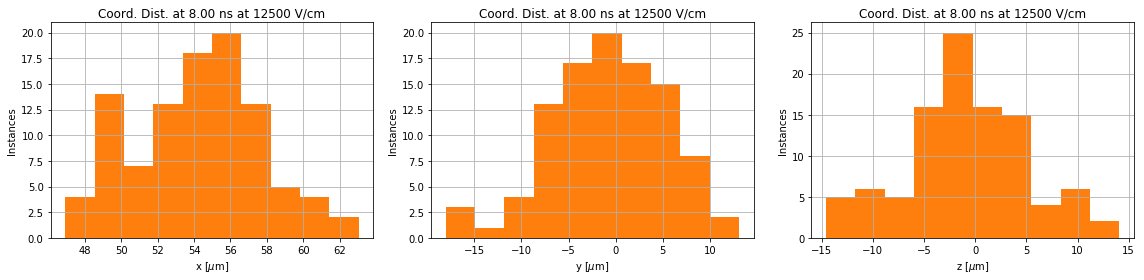

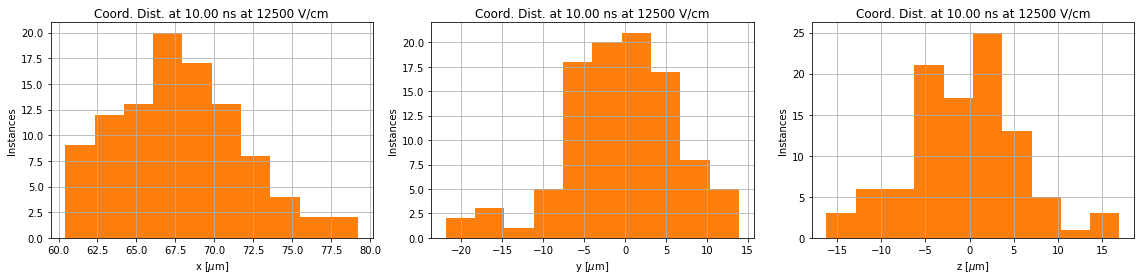

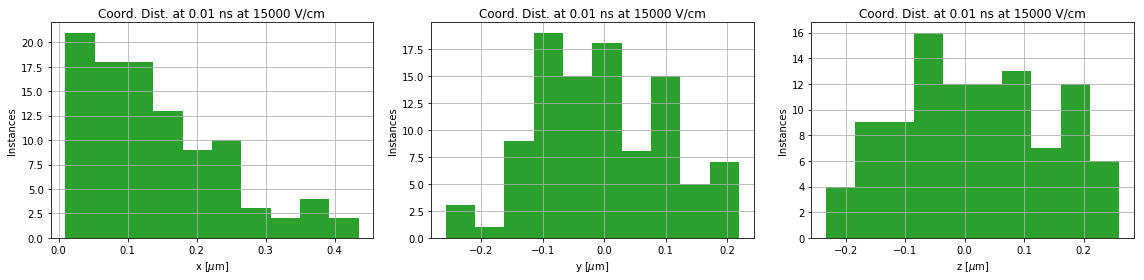

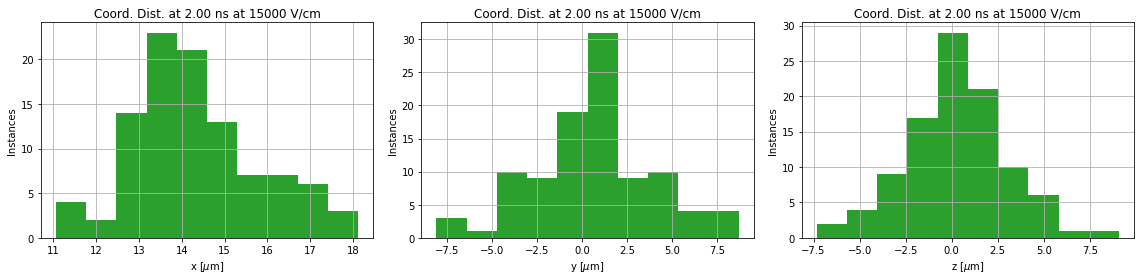

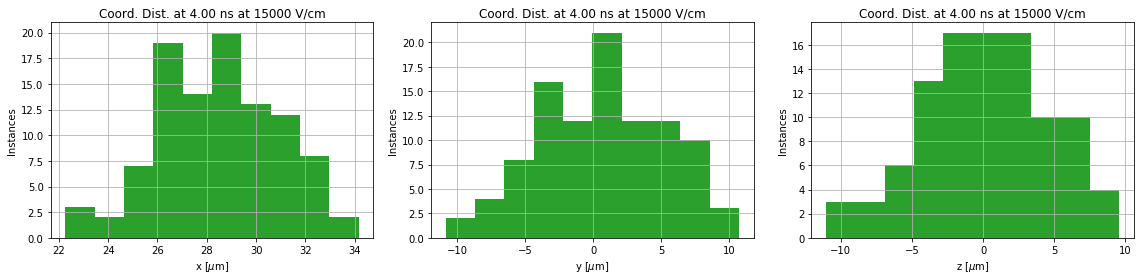

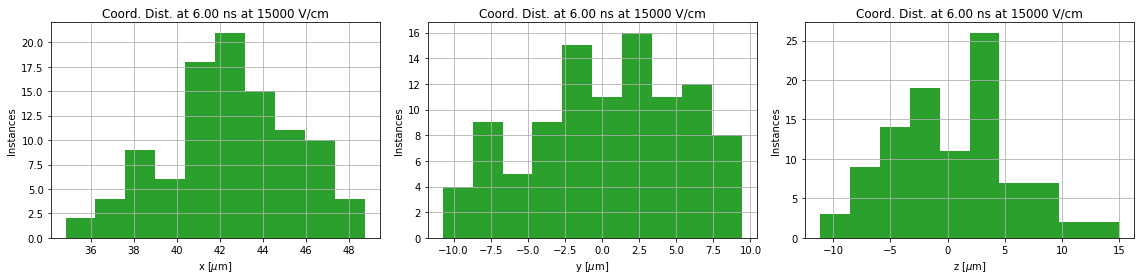

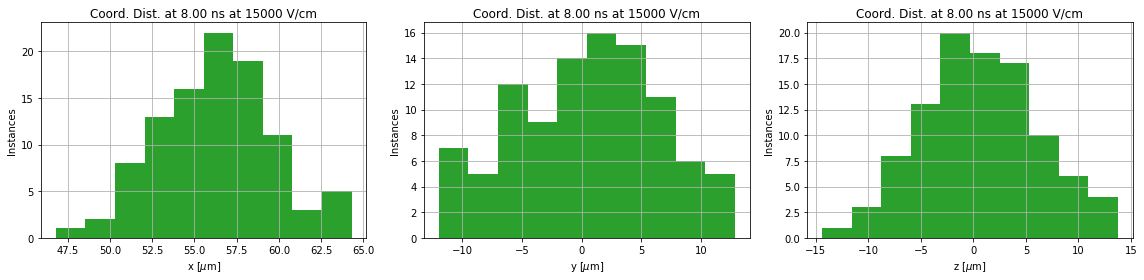

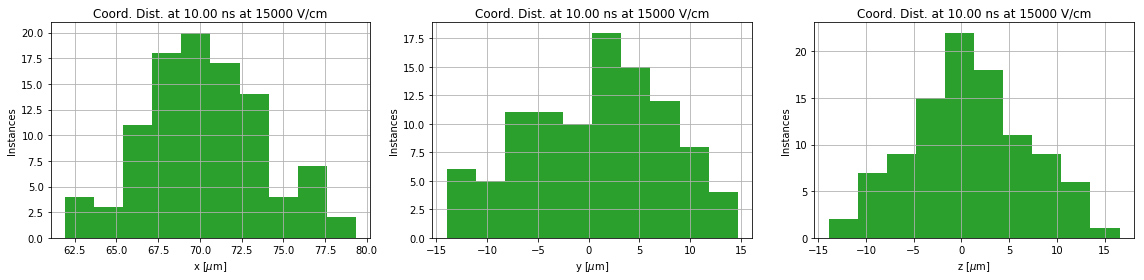

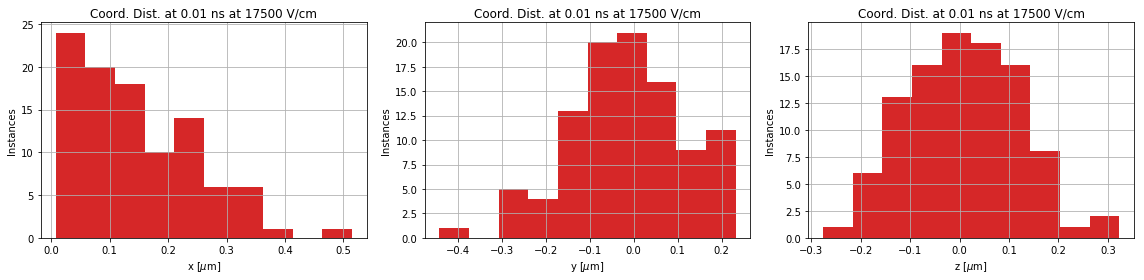

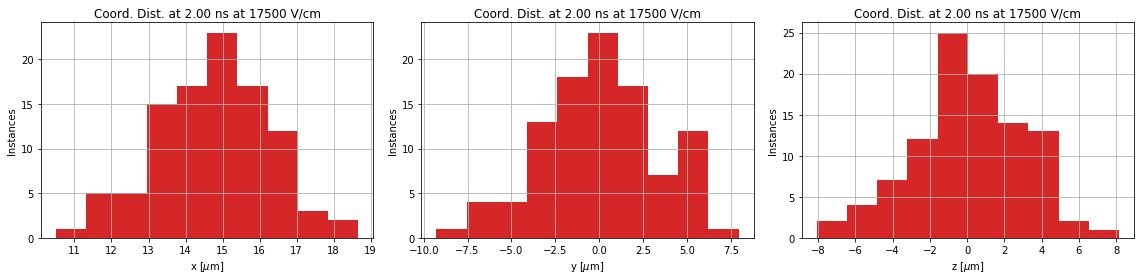

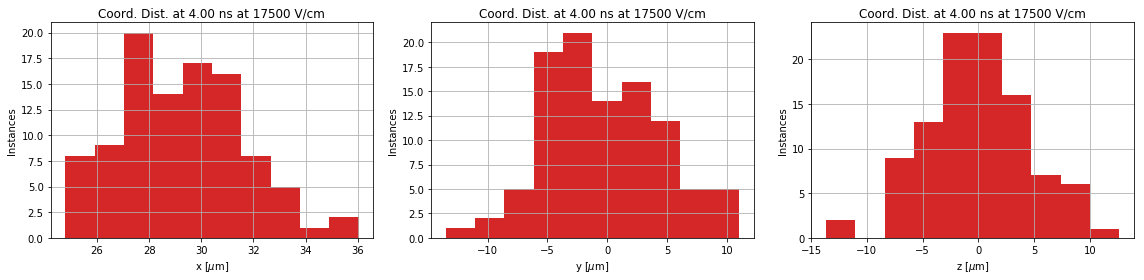

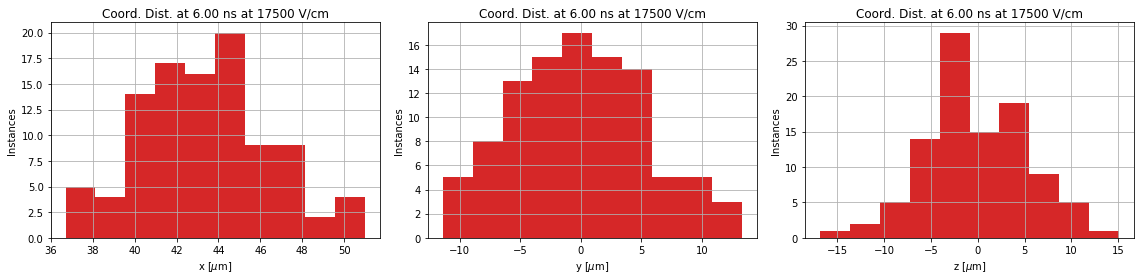

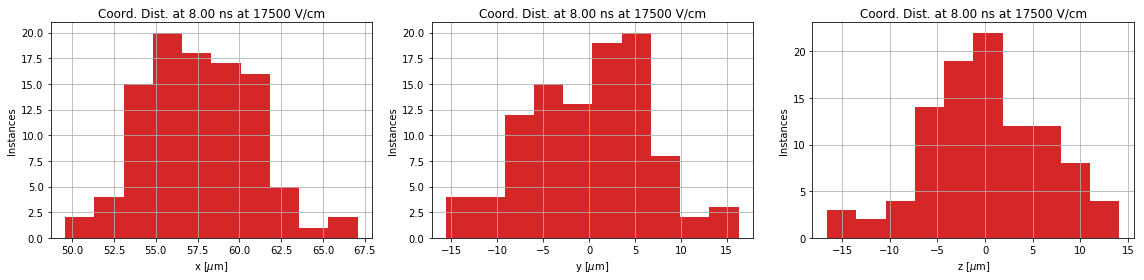

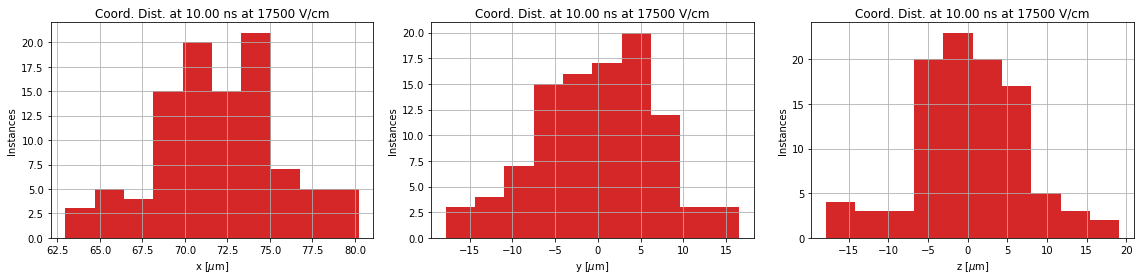

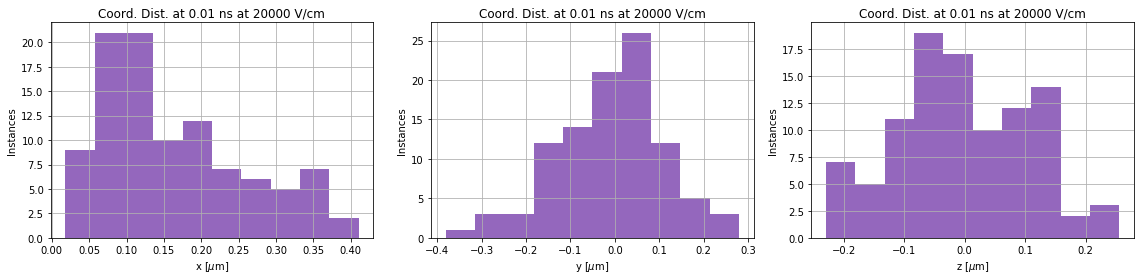

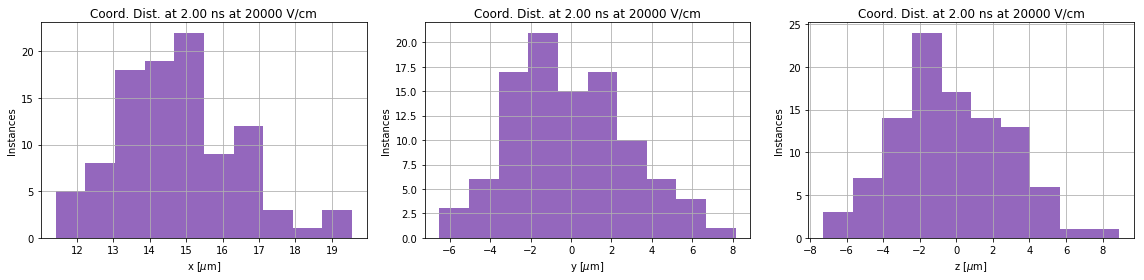

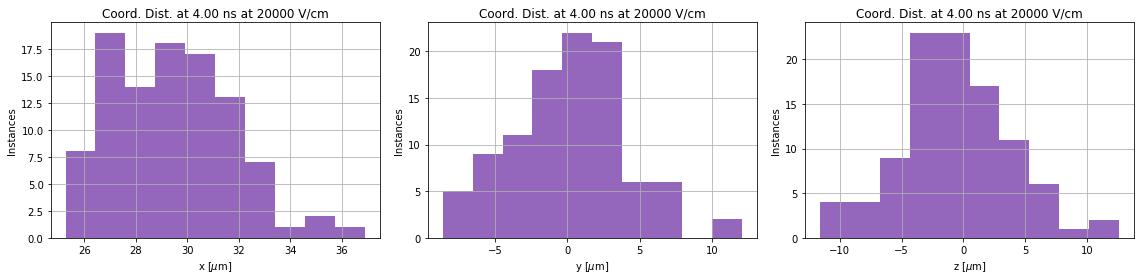

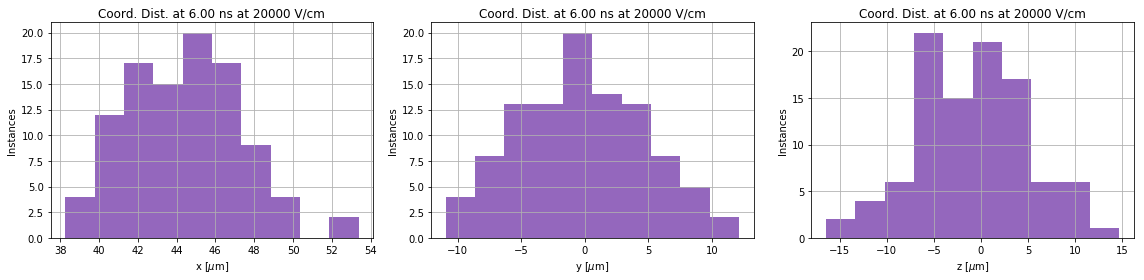

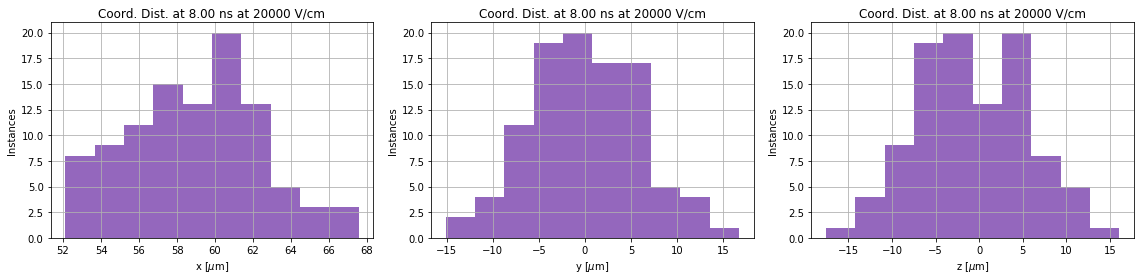

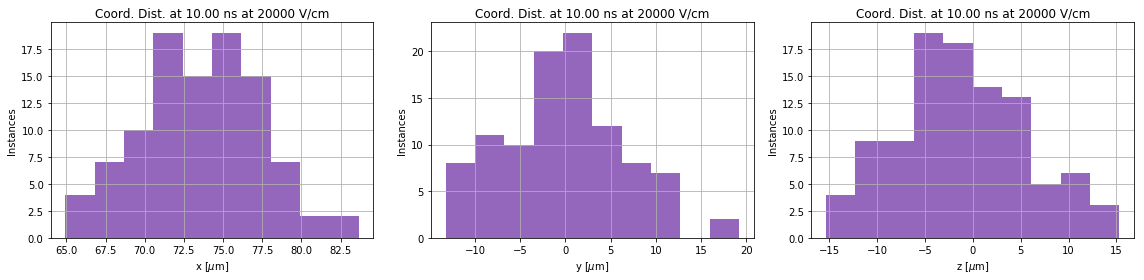

In [39]:
i = 0

for key, value in sorted(file_tree.items()):
    group = Graph(value)
    min_length = np.amin([len(k) for k in group.t])

    for k in range(0, min_length, round(len(group.t[0]) / 5)):
        x = []
        y = []
        z = []
        for j in range(group.n):
            x.append(group.x[j][k])
            y.append(group.y[j][k])
            z.append(group.z[j][k])

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

        plots = [x, y, z]
        labels = ['x', 'y', 'z']
        
        plt.grid()

        for j, subplot in enumerate([ax1, ax2, ax3]):
            subplot.grid()
            subplot.hist(plots[j], color=f'C{i}')
            subplot.set_xlabel(labels[j] + ' [$\mu$m]')
            subplot.set_ylabel('Instances')
            subplot.set_title(f'Coord. Dist. at {group.t[0][k]:.2f} ns at {key} V/cm')

        plt.grid()
        plt.tight_layout()
        plt.show()

    i += 1
    if i > 9:
        i = 0